In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib.patches import Circle
import umap.umap_ as umap

URL_DATA = '/content/drive/MyDrive/AI-Discovery-of-Unknown-Multi-Disease-Phenotypes-in-Longitudinal-Electronic-Health-Records/physionet.org/files/mimic-iv-demo/2.2/'
URL_PROJECT = '/content/drive/MyDrive/AI-Discovery-of-Unknown-Multi-Disease-Phenotypes-in-Longitudinal-Electronic-Health-Records/'

ModuleNotFoundError: No module named 'umap.umap_'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## These tables provide the foundational demographic and administrative information, crucial for identifying unique patients and their hospital encounters.

`patients.csv.gz`:

* `subject_id`: Unique patient identifier (critical for linking all other tables).
* `gender`: Male/Female.
* `anchor_age`, `anchor_year`, `anchor_year_group`: De-identified age and year information. Used to infer approximate real age and hospitalization year while preserving privacy.
* `dod` (Date of Death): If available, an important outcome variable.
Purpose: Demographics, patient linking, age calculation, mortality outcome.
`admissions.csv.gz`:
* `subject_id`, `hadm_id`: Unique hospital admission identifier (links to all hospital-level events).
* `admittime`, `dischtime`: Admission and discharge timestamps.
* `deathtime`: Time of death during hospitalization (if applicable).
* `admission_type`, `admission_location`, `discharge_location`: Context of admission and discharge.
* `hospital_expire_flag`: Binary flag indicating in-hospital death.
* `language`, `ethnicity`, `marital_status`, `religion`: Socio-demographic context.
  * Purpose: Define hospital stays, calculate Length of Stay (LOS), identify readmissions, capture admission context, patient-level outcomes.

`transfers.csv.gz`:

* `subject_id`, `hadm_id`, `transfer_id`: Identifiers for transfer events within the hospital.
* `intime`, `outtime`: Transfer in and out times for specific hospital units/wards.
* `careunit`: The care unit the patient was transferred to.
 * Purpose: Detailed longitudinal tracking of patient movement within the hospital, especially between different wards.
II. Clinical Data for Phenotype Discovery (primarily from `/hosp` and `/icu`):

This is where the rich, longitudinal clinical data for identifying multi-disease phenotypes resides.

`diagnoses_icd.csv.gz` (from `/hosp`):

* `subject_id`, `hadm_id`, `seq_num`: Patient, admission, and sequence number of diagnosis (important for primary diagnosis).
* `icd_code`, `icd_version`: ICD (International Classification of Diseases) codes (both ICD-9 and ICD-10 in MIMIC-IV).
 * Purpose: Core for defining diseases and comorbidities. You'll need to map these to higher-level disease categories (e.g., using Clinical Classification Software (CCS) categories or custom groupings) to abstract phenotypes.

`d_icd_diagnoses.csv.gz` (from `/hosp`):

* `icd_code`, `long_title`: Provides human-readable descriptions for ICD codes.
 * Purpose: To interpret and categorize `diagnoses_icd` codes.

`labevents.csv.gz` (from `/hosp`):

* `subject_id`, `hadm_id`, `itemid`: Identifiers.
* `charttime`: Timestamp of the lab test.
* `valuenum`, `valueuom`: Numerical result and unit of measurement.
* `flag`: Abnormal flag.
 * Purpose: Longitudinal physiological status, identifying abnormal trends, and creating features like `mean`, `min`, `max`, standard deviation, and trends of various biomarkers (e.g., creatinine, white blood cell count, sodium, potassium).

`d_labitems.csv.gz` (from `/hosp`):

* `itemid`, `label`, `loinc_code`: Descriptions for labevents itemids.
 * Purpose: To understand and filter specific lab tests.

`chartevents.csv.gz` (from `/icu`):

* `subject_id`, `hadm_id`, `icustay_id`: Identifiers.
* `charttime`: Timestamp of the observation.
* `itemid`: Identifier for the type of observation (e.g., heart rate, blood pressure).
* `valuenum`, `valueuom`: Numerical value and unit.
 * Purpose: High-resolution longitudinal data on vital signs, physical assessments, and clinical scores (e.g., GCS, RASS). Crucial for capturing acute changes and patient trajectory within the ICU.

`d_items.csv.gz` (from `/icu`):

* `itemid`, `label`, `category`, `unitname`: Descriptions for chartevents itemids.
 * Purpose: To understand and filter specific vital signs and chart observations.

`prescriptions.csv.gz` (from `/hosp`):

* `subject_id`, `hadm_id`, `starttime`, `stoptime`: Patient, admission, and medication administration times.
* `drug`, `dose_val_rx`, `dose_unit_rx`: Medication name, dosage, and unit.
* `route`: Administration route.
 * Purpose: Medication history, identifying drug classes, polypharmacy, and specific treatments associated with certain phenotypes.

`procedures_icd.csv.gz` (from `/hosp`):

* `subject_id`, `hadm_id`, `icd_code`, `icd_version`: Procedure codes (ICD-9 and ICD-10).
* `seq_num`: Sequence of procedure.
 * Purpose: Identify interventions and treatments, which can be part of a phenotype definition or a response to disease.


`d_icd_procedures.csv.gz` (from `/hosp`):

* `icd_code`, `long_title`: Descriptions for procedure codes.
 * Purpose: To interpret procedures_icd codes.

`icustays.csv.gz` (from `/icu`):

* `subject_id`, `hadm_id`, `icustay_id`: Unique ICU stay identifier.
* `intime`, `outtime`: ICU admission and discharge times.
* `first_careunit`, `last_careunit`: Specific ICU units (e.g., MICU, SICU, CCU).
* `los`: Length of stay in ICU.
 * Purpose: Define ICU episodes, calculate ICU LOS, track unit transfers within critical care.

`inputevents.csv.gz` / `outputevents.csv.gz` (from `/icu`):

* `subject_id`, `hadm_id`, `icustay_id`, `charttime`: Identifiers and timestamps.
* `itemid`, `amount`, `amountuom`: Type of input/output, quantity, and unit.
 * Purpose: Fluid balance, medication infusions (`inputevents`), urine output, drain outputs (outputevents). Can reflect renal function, hydration status, etc.
III. Less Commonly Used but Potentially Useful Tables (for advanced phenotyping):

`drgcodes.csv.gz` (from `/hosp`):
* Diagnosis Related Group (DRG) codes, used for billing and resource utilization. Can be an outcome or summary feature.

`microbiologyevents.csv.gz` (from `/hosp`):

* Culture results, identification of pathogens, and antibiotic susceptibilities. Crucial for infectious disease phenotypes.

`pharmacy.csv.gz` (from `/hosp`):

* Detailed pharmacy orders (often overlaps with prescriptions).

`poe.csv.gz` / `poe_detail.csv.gz` (from `/hosp`):

* Provider order entry system data. Can give insight into clinician actions.


`services.csv.gz` (from `/hosp`):

Hospital services involved in patient care (e.g., Cardiology, General Medicine).

`datetimeevents.csv.gz` (from `/icu`): Events with date/time values (e.g., last menstrual period, exam findings).

`procedureevents.csv.gz` (from `/icu`): More granular details on procedures performed in the ICU.

# Key Steps in Utilizing this Data for AI Phenotype Discovery:

* Patient Cohort Definition: Define who you are including (e.g., all adults, patients with multiple admissions, first ICU stay).
* Temporal Alignment: All events are linked by `subject_id`, `hadm_id`, and `icustay_id`, and critically, by `charttime`, `admittime`, `dischtime`, `intime`, `outtime`. You'll need to align these events chronologically.

# Feature Engineering:
* Static Features: Age, gender, ethnicity, admission type, primary diagnosis.

* Aggregated Longitudinal Features: For time-series data (labs, vitals, medications):

# Summary Statistics:
* Mean, median, min, max, standard deviation, variance of values over a specific period (e.g., first 24 hours of ICU stay, entire hospital stay).

 * Trends: Slope of values over time.
 * Frequency/Counts: Number of abnormal lab values, number of unique medications, number of procedures.
 * Categorical Encoding: One-hot encode diagnoses, procedures, medication classes.
 * Time-Series Representation: For more advanced models (RNNs, LSTMs), you might keep the raw time-series of key lab values or vital signs, potentially binned into time intervals.
 * Missing Data Imputation: Handle NaN values (e.g., median imputation, forward fill, or more sophisticated methods like MICE).
 * Dimensionality Reduction/Clustering: Once features are extracted, apply techniques like PCA, UMAP, or t-SNE for visualization and dimensionality reduction, followed by clustering algorithms (K-Means, Hierarchical Clustering, DBSCAN, Gaussian Mixture Models) to identify the "unknown multi-disease phenotypes."

 * Phenotype Characterization: After clustering, analyze the clinical characteristics of each cluster (e.g., what are the most common diagnoses, lab abnormalities, medications, or outcomes within each identified group?) to interpret and name your discovered phenotypes.

* By systematically extracting, processing, and integrating data from these MIMIC-IV tables, you can create a rich feature set suitable for AI-driven discovery of complex patient phenotypes.

#Feature Engineering

We extract relevant features from merged patient, admissions and diagnoses-to-ICD using Principal Component Analysis (PCA)

In [3]:
patients = pd.read_csv(f"{URL_DATA}hosp/patients.csv.gz")
admissions = pd.read_csv(f"{URL_DATA}hosp/admissions.csv.gz")
diagnoses = pd.read_csv(f"{URL_DATA}hosp/diagnoses_icd.csv.gz")

# Merge demographic and admission data
df = admissions.merge(patients, on="subject_id", how="left")

# Age approximation
df['approx_age'] = df['anchor_age']

# Mortality label
df['died_in_hospital'] = df['hospital_expire_flag']

# Encode gender
df['gender'] = df['gender'].map({'M': 0, 'F': 1})

# Count number of diagnoses
diag_counts = diagnoses.groupby('hadm_id').size().reset_index(name='num_diagnoses')
df = df.merge(diag_counts, on='hadm_id', how='left')
df['num_diagnoses'] = df['num_diagnoses'].fillna(0)

# Calculate length of stay
df['admittime'] = pd.to_datetime(df['admittime'])
df['dischtime'] = pd.to_datetime(df['dischtime'])
df['length_of_stay'] = (df['dischtime'] - df['admittime']).dt.total_seconds() / (60 * 60 * 24)

# Select relevant columns
features = df[[
    'subject_id', 'hadm_id', 'approx_age', 'gender', 'num_diagnoses',
    'length_of_stay', 'died_in_hospital'
]]

In [4]:
def elbow_method(df, max_k=10):
    X = df.drop(columns=['subject_id', 'hadm_id'])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    inertias = []
    ks = range(1, max_k + 1)

    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(ks, inertias, 'bo-')
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
    plt.title("Elbow Method for Optimal k")
    plt.grid(True)
    plt.show()
scaler = StandardScaler()
kmeans = KMeans();
def run_clustering(df, n_clusters=4):
    ids = df[['subject_id', 'hadm_id']]
    X = df.drop(columns=['subject_id', 'hadm_id'])

    # Normalize
    X_scaled = scaler.fit_transform(X)

    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(X_scaled)
    df['cluster'] = labels

    # PCA for comparison (optional)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # 🌐 UMAP embedding
    reducer = umap.UMAP(random_state=42)
    X_umap = reducer.fit_transform(X_scaled)

    # Plot UMAP
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels, palette="Set2", s=40)
    plt.title("UMAP Visualization of Clusters")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.grid(True)
    plt.show()

    return df



In [5]:
features = features.dropna()
features.head(10)

,subject_id,hadm_id,approx_age,gender,num_diagnoses,length_of_stay,died_in_hospital
0,10004235,24181354,47,0,26,8.975000,0
1,10009628,25926192,58,0,8,7.841667,0
2,10018081,23983182,79,0,19,5.731250,0
3,10006053,22942076,52,0,10,1.736806,1
4,10031404,21606243,82,1,15,2.090972,0
5,10005817,20626031,66,0,26,8.556250,0
6,10019385,20297618,44,0,9,9.720139,0
7,10002495,24982426,81,0,26,6.891667,0
8,10038081,20755971,63,1,38,14.138889,1
9,10019917,22585261,44,0,4,2.727083,0


We can see that the optimal number of clusters required is 4-6. We chose 5.

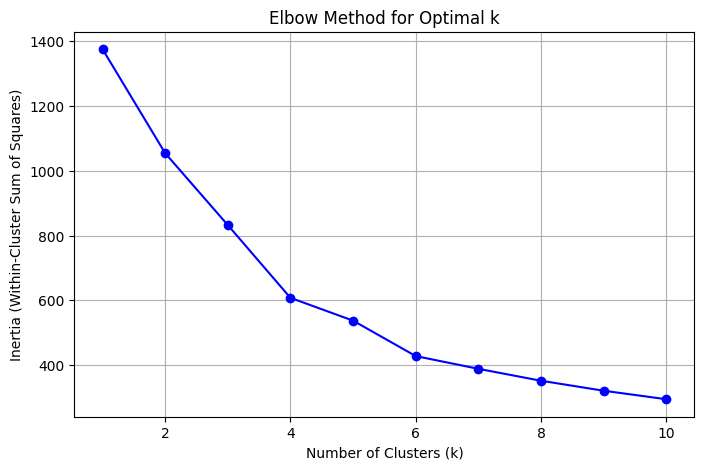

In [6]:
elbow_method(features)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


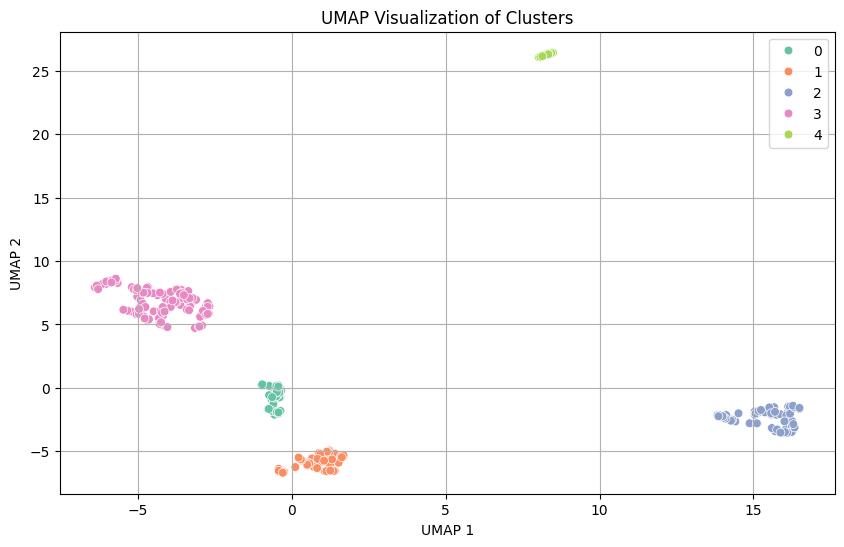

In [11]:
clustered_df = run_clustering(features, 5)

We sort the updated DataFrame with designated clusters in `clustered_df`. We then get the mean and standard deviation for each column that is continuous.

In [12]:
cluster_stats = clustered_df.groupby('cluster').agg({
        'approx_age': ['mean', 'std'],
        'gender': 'mean',  # closer to 0 = male, closer to 1 = female
        'num_diagnoses': ['mean', 'std'],
        'length_of_stay': ['mean', 'std'],
        'died_in_hospital': ['mean']
    })

In [13]:
print(cluster_stats)

        approx_age               gender num_diagnoses            \
              mean        std      mean          mean       std   
cluster                                                           
0        60.864865  12.680173  0.378378     28.432432  6.962361   
1        46.370370  10.336410  1.000000     11.388889  5.457958   
2        74.274194   9.626073  1.000000     16.677419  6.841949   
3        59.794393  11.791217  0.000000     13.046729  6.927363   
4        68.533333  11.363266  0.200000     27.266667  9.661904   

        length_of_stay           died_in_hospital  
                  mean       std             mean  
cluster                                            
0            18.755668  8.095932              0.0  
1             4.440316  3.132193              0.0  
2             4.406877  2.989393              0.0  
3             4.860540  3.390616              0.0  
4            10.915324  9.187328              1.0  


In [16]:
from tabulate import tabulate

summary = clustered_df.groupby('cluster').agg({
    'approx_age': ['mean', 'std'],
    'gender': 'mean',
    'num_diagnoses': ['mean', 'std'],
    'length_of_stay': ['mean', 'std'],
    'died_in_hospital': 'mean'
}).round(2)

print(tabulate(summary, headers='keys', tablefmt='github'))


|   cluster |   ('approx_age', 'mean') |   ('approx_age', 'std') |   ('gender', 'mean') |   ('num_diagnoses', 'mean') |   ('num_diagnoses', 'std') |   ('length_of_stay', 'mean') |   ('length_of_stay', 'std') |   ('died_in_hospital', 'mean') |
|-----------|--------------------------|-------------------------|----------------------|-----------------------------|----------------------------|------------------------------|-----------------------------|--------------------------------|
|         0 |                    60.86 |                   12.68 |                 0.38 |                       28.43 |                       6.96 |                        18.76 |                        8.1  |                              0 |
|         1 |                    46.37 |                   10.34 |                 1    |                       11.39 |                       5.46 |                         4.44 |                        3.13 |                              0 |
|         2 |               

# Cluster Analysis Results

We identified five distinct patient phenotypes based on clustering demographic and clinical features from MIMIC-IV data:

| Cluster | Avg Age | % Female | Avg Diagnoses | Avg Length of Stay (days) | Mortality Rate | Interpretation                                                                                                                                      |
| ------- | ------- | -------- | ------------- | ------------------------- | -------------- | --------------------------------------------------------------------------------------------------------------------------------------------------- |
| **0**   | 60.9    | 37.8%    | 28.4          | 18.8                      | 0.0%           | Chronically ill older adults with long hospital stays and high comorbidity, but no recorded in-hospital deaths. Likely a stable, managed phenotype. |
| **1**   | 46.4    | 100%     | 11.4          | 4.4                       | 0.0%           | Young, low-risk female patients. Likely admitted for short-term, low-complexity care such as post-operative recovery.                               |
| **2**   | 74.3    | 100%     | 16.7          | 4.4                       | 0.0%           | Elderly female patients with moderate diagnosis burden. Despite age, outcomes suggest stable, well-managed conditions.                              |
| **3**   | 59.8    | 0.0%     | 13.0          | 4.9                       | 0.0%           | Middle-aged male patients with moderate complexity. Short stays and no in-hospital deaths point to low to moderate risk.                            |
| **4**   | 68.5    | 20.0%    | 27.3          | 10.9                      | **100.0%**     | Critically ill patients with extensive diagnoses, long stays, and full in-hospital mortality. Likely representing end-stage or multi-organ failure. |



 MIMIC-III, a freely accessible critical care database: https://doi.org/10.1038/sdata.2016.35

 An unsupervised representation to predict the future of patients from the electronic health records. Scientific Reports, 6, 26094. https://doi.org/10.1038/srep26094

---

# Next Steps

1. **Create Visualizations**  
   - Bar plots for mortality, length of stay, and diagnoses by cluster.  
   - PCA or UMAP scatterplots colored by cluster.

2. **Evaluate Clustering Quality**  
   - Compute silhouette scores or other metrics.

3. **Interpret Phenotypes**  
   - Draft clinical interpretations of each cluster.  
   - Relate findings to existing medical literature.

4. **Optional Temporal Analysis**  
   - Explore changes in patient features over time if longitudinal data are available.

5. **Prepare Report Materials**  
   - Save figures and tables for inclusion in your Regeneron submission.  
   - Begin drafting Introduction, Methods, and Results sections.

---

Let me know if you want me to help with code for visualization, cluster evaluation, or writing!


In [17]:
X = clustered_df.drop(columns=['cluster', 'subject_id', 'hadm_id'])
y = clustered_df['cluster']


# SHAP Analysis

To uncover the drivers behind each of the discovered phenotypes represented by the clusters, we trained a supervised Random Forest Classifier Model to predict cluster features based on clinical features

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.85      1.00      0.92        11
           2       1.00      0.83      0.91        12
           3       0.91      1.00      0.95        21
           4       1.00      1.00      1.00         3

    accuracy                           0.93        55
   macro avg       0.95      0.92      0.93        55
weighted avg       0.94      0.93      0.93        55



There is a considerable detection in features identified by the high f1 and accuracy, showing phenotype traits separated by clusters.

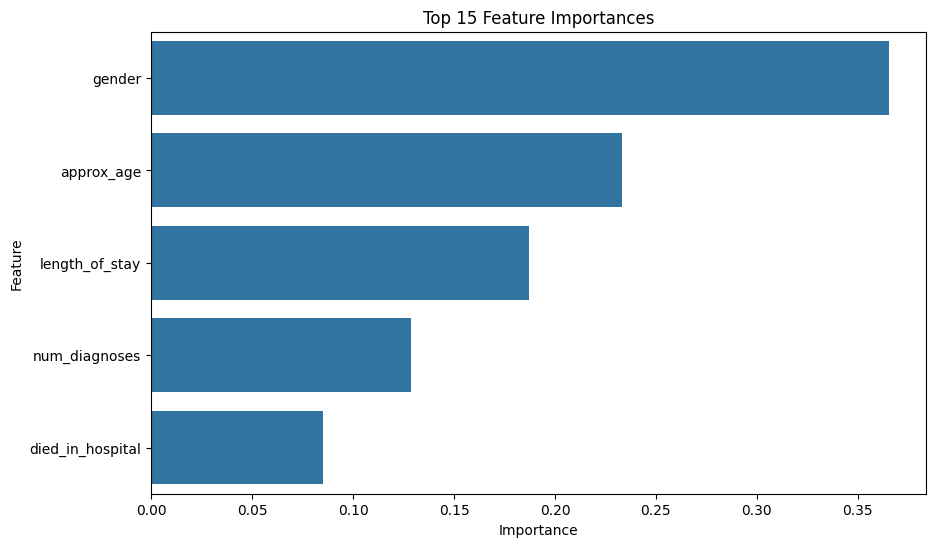

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Top 15 Feature Importances')
plt.show()


The plot shows gender as separating the features apart

# SHAP Analysis for Understanding Decision-Making Behind our Model

SHAP provides local and global explainability, helping us identify:

* Which features are most influential across all clusters
* How feature values (high vs. low) impact model predictions for each phenotype

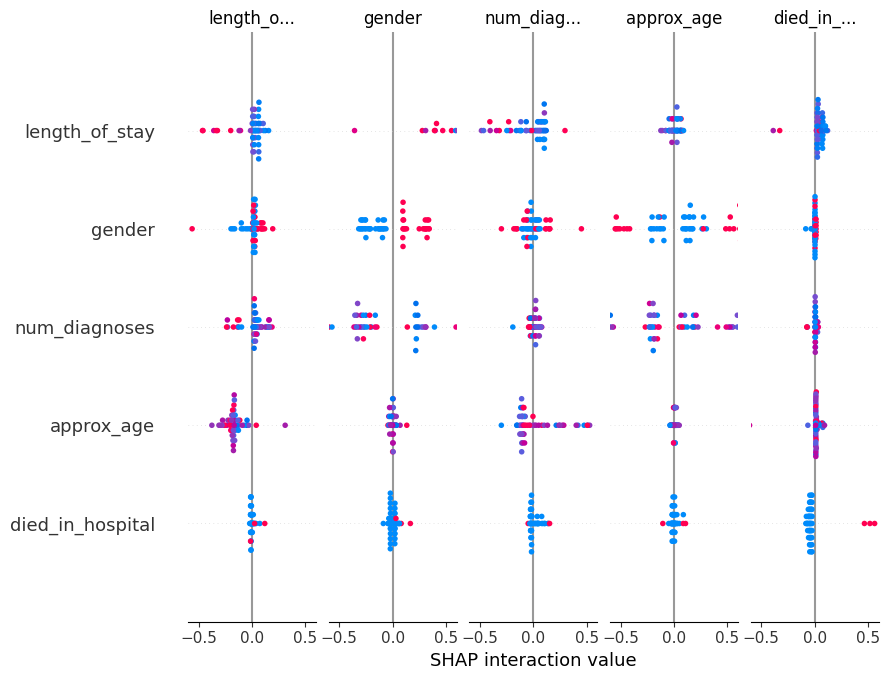

In [21]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)


# Notable Characteristics

| Feature                | Key Interaction Observations                                                                                                                                                                                          |
| ---------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **length\_of\_stay**   | High `length_of_stay` (red) increases SHAP interaction values when combined with high `died_in_hospital` and high `num_diagnoses`, suggesting these features co-contribute to the prediction of high-risk phenotypes. |
| **gender**             | Male patients (blue) tend to reduce the SHAP value when interacting with most features, indicating that **female patients may be more likely to belong to certain phenotypes** (e.g., low-risk groups).               |
| **num\_diagnoses**     | The interaction with `died_in_hospital` and `length_of_stay` appears strongest — consistent with **high diagnosis count correlating with critical phenotypes**.                                                       |
| **approx\_age**        | Age appears to slightly increase SHAP values when interacting with `length_of_stay` and `num_diagnoses`, indicating that **older patients with long stays and many diagnoses** are pushed toward high-risk clusters.  |
| **died\_in\_hospital** | Strong positive interaction with `length_of_stay` and `num_diagnoses` — consistent with the high-mortality phenotype (Cluster 4) discovered earlier.                                                                  |
